In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
df = pd.read_csv('logits-eval-old.csv')

for model in df['model'].unique():
    root_dir = f"/mnt/align4_drive/arunas/rm-interp/sycophancy/gen-flow/runs/{model}/"
    for task in df['task'].unique():
        for method in df['method'].unique():
            method_dir = os.path.join(root_dir, f"from_{task}", method, 'eval/')
            for sf in df['N'].unique():
                for topk in df['topk'].unique():
                    if topk == 1.0:
                        topk = 1
                    filename = (
                            f"{sf}_targeted_steer_topk_{topk}_gen_accuracy.json"
                            if method != "random"
                            else f"{sf}_random_steer_topk_{topk}_gen_accuracy.json"
                        )
                    filepath = os.path.join(method_dir, filename)
                    with open(filepath, 'r') as f:
                        data = json.load(f)
                        try:
                            accuracy = data.get(f"gen").get("q1", np.nan)
                        except:
                            accuracy = data.get("q1", np.nan)
                    df.loc[
                        (df['model'] == model) &
                        (df['task'] == task) &
                        (df['method'] == method) &
                        (df['N'] == sf) &
                        (df['topk'] == topk),
                        'gen_accuracy'
                    ] = accuracy
df.to_csv('logits-eval-acc.csv', index=False)                

df = pd.read_csv('logits-eval-acc.csv')
import pandas as pd
from scipy.stats import spearmanr

def spearman_against_accuracy(df):
    metrics = [
        "Wasserstein","KS","Energy","Spearman",
        "Delta_mean","Delta_median","Delta_IQR","Frac_delta_pos",
        "Cohens_d","Overlap","t_p","wilcoxon_p"
    ]

    results = []
    for (model, task, method), sub in df.groupby(["model","task","method"]):
        for metric in metrics:
            # Round values to 2 decimals before computing Spearman
            x = np.round(sub["gen_accuracy"], 2)
            y = np.round(sub[metric], 2)

            if metric == 'Spearman':
                y = -y

            rho, p = spearmanr(x, y)
            results.append({
                "model": model,
                "task": task,
                "method": method,
                "metric": metric,
                "spearman_rho": round(rho, 2),
                "p_value": round(p, 2)
            })

    return pd.DataFrame(results)

# Example usage
corr_df = spearman_against_accuracy(df)
corr_df.to_csv('logits-eval-acc-corr-rounded.csv', index=False)

/tmp/ipykernel_1030617/1877501184.py:61: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(x, y)


In [66]:
import pandas as pd

# Load your CSV of correlations
df = pd.read_csv("logits-eval-acc-corr-rounded.csv")

# Drop rows with missing rhos
df = df.dropna(subset=["spearman_rho"])

# Take absolute value for ranking
df["abs_rho"] = df["spearman_rho"].abs()

# For each model-task-method, pick max |rho|
best = df.loc[df.groupby(["model","task","method"])["abs_rho"].idxmax()]

print(best[["model","task","method","metric","spearman_rho"]])


                         model                 task    method          metric  \
9          OLMo-2-1124-13B-DPO  harmful_to_harmless       acp         Overlap   
13         OLMo-2-1124-13B-DPO  harmful_to_harmless       atp              KS   
27         OLMo-2-1124-13B-DPO  harmful_to_harmless  atp-zero        Spearman   
45         OLMo-2-1124-13B-DPO  harmful_to_harmless    probes         Overlap   
49         OLMo-2-1124-13B-DPO  harmful_to_harmless    random              KS   
65         OLMo-2-1124-13B-DPO         hate_to_love       acp    Delta_median   
81         OLMo-2-1124-13B-DPO         hate_to_love       atp         Overlap   
89         OLMo-2-1124-13B-DPO         hate_to_love  atp-zero    Delta_median   
101        OLMo-2-1124-13B-DPO         hate_to_love    probes    Delta_median   
113        OLMo-2-1124-13B-DPO         hate_to_love    random    Delta_median   
123        OLMo-2-1124-13B-DPO       verse_to_prose       acp        Spearman   
135        OLMo-2-1124-13B-D

/tmp/ipykernel_1030617/1548194323.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormaps = [cm.get_cmap('viridis'), cm.get_cmap('plasma'), cm.get_cmap('cividis')]


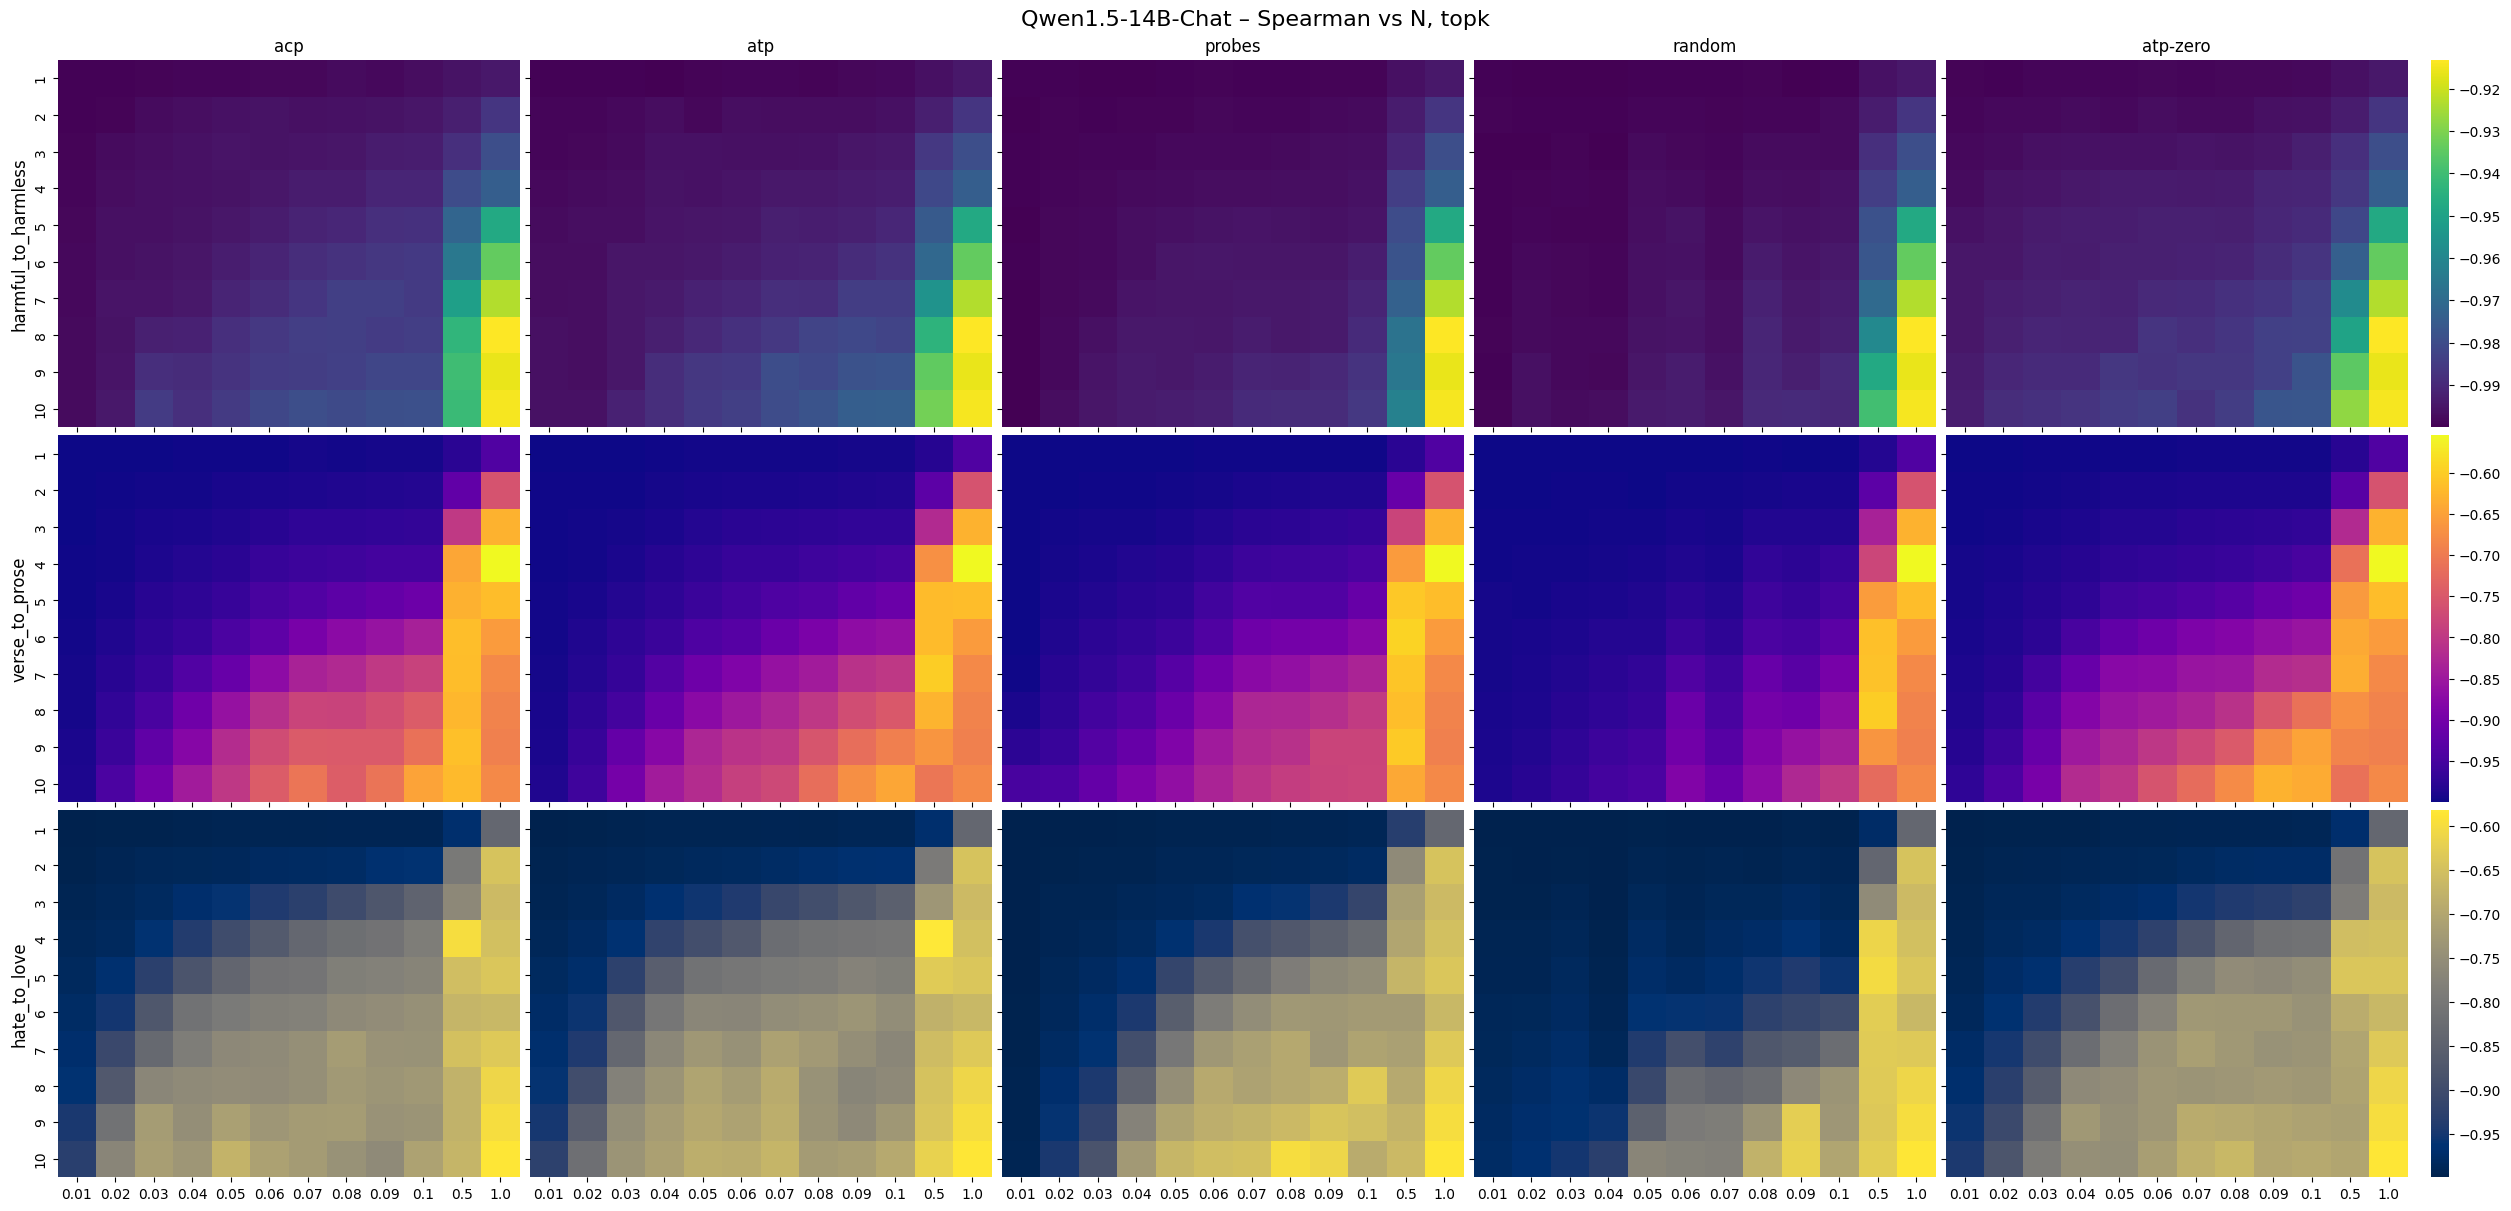

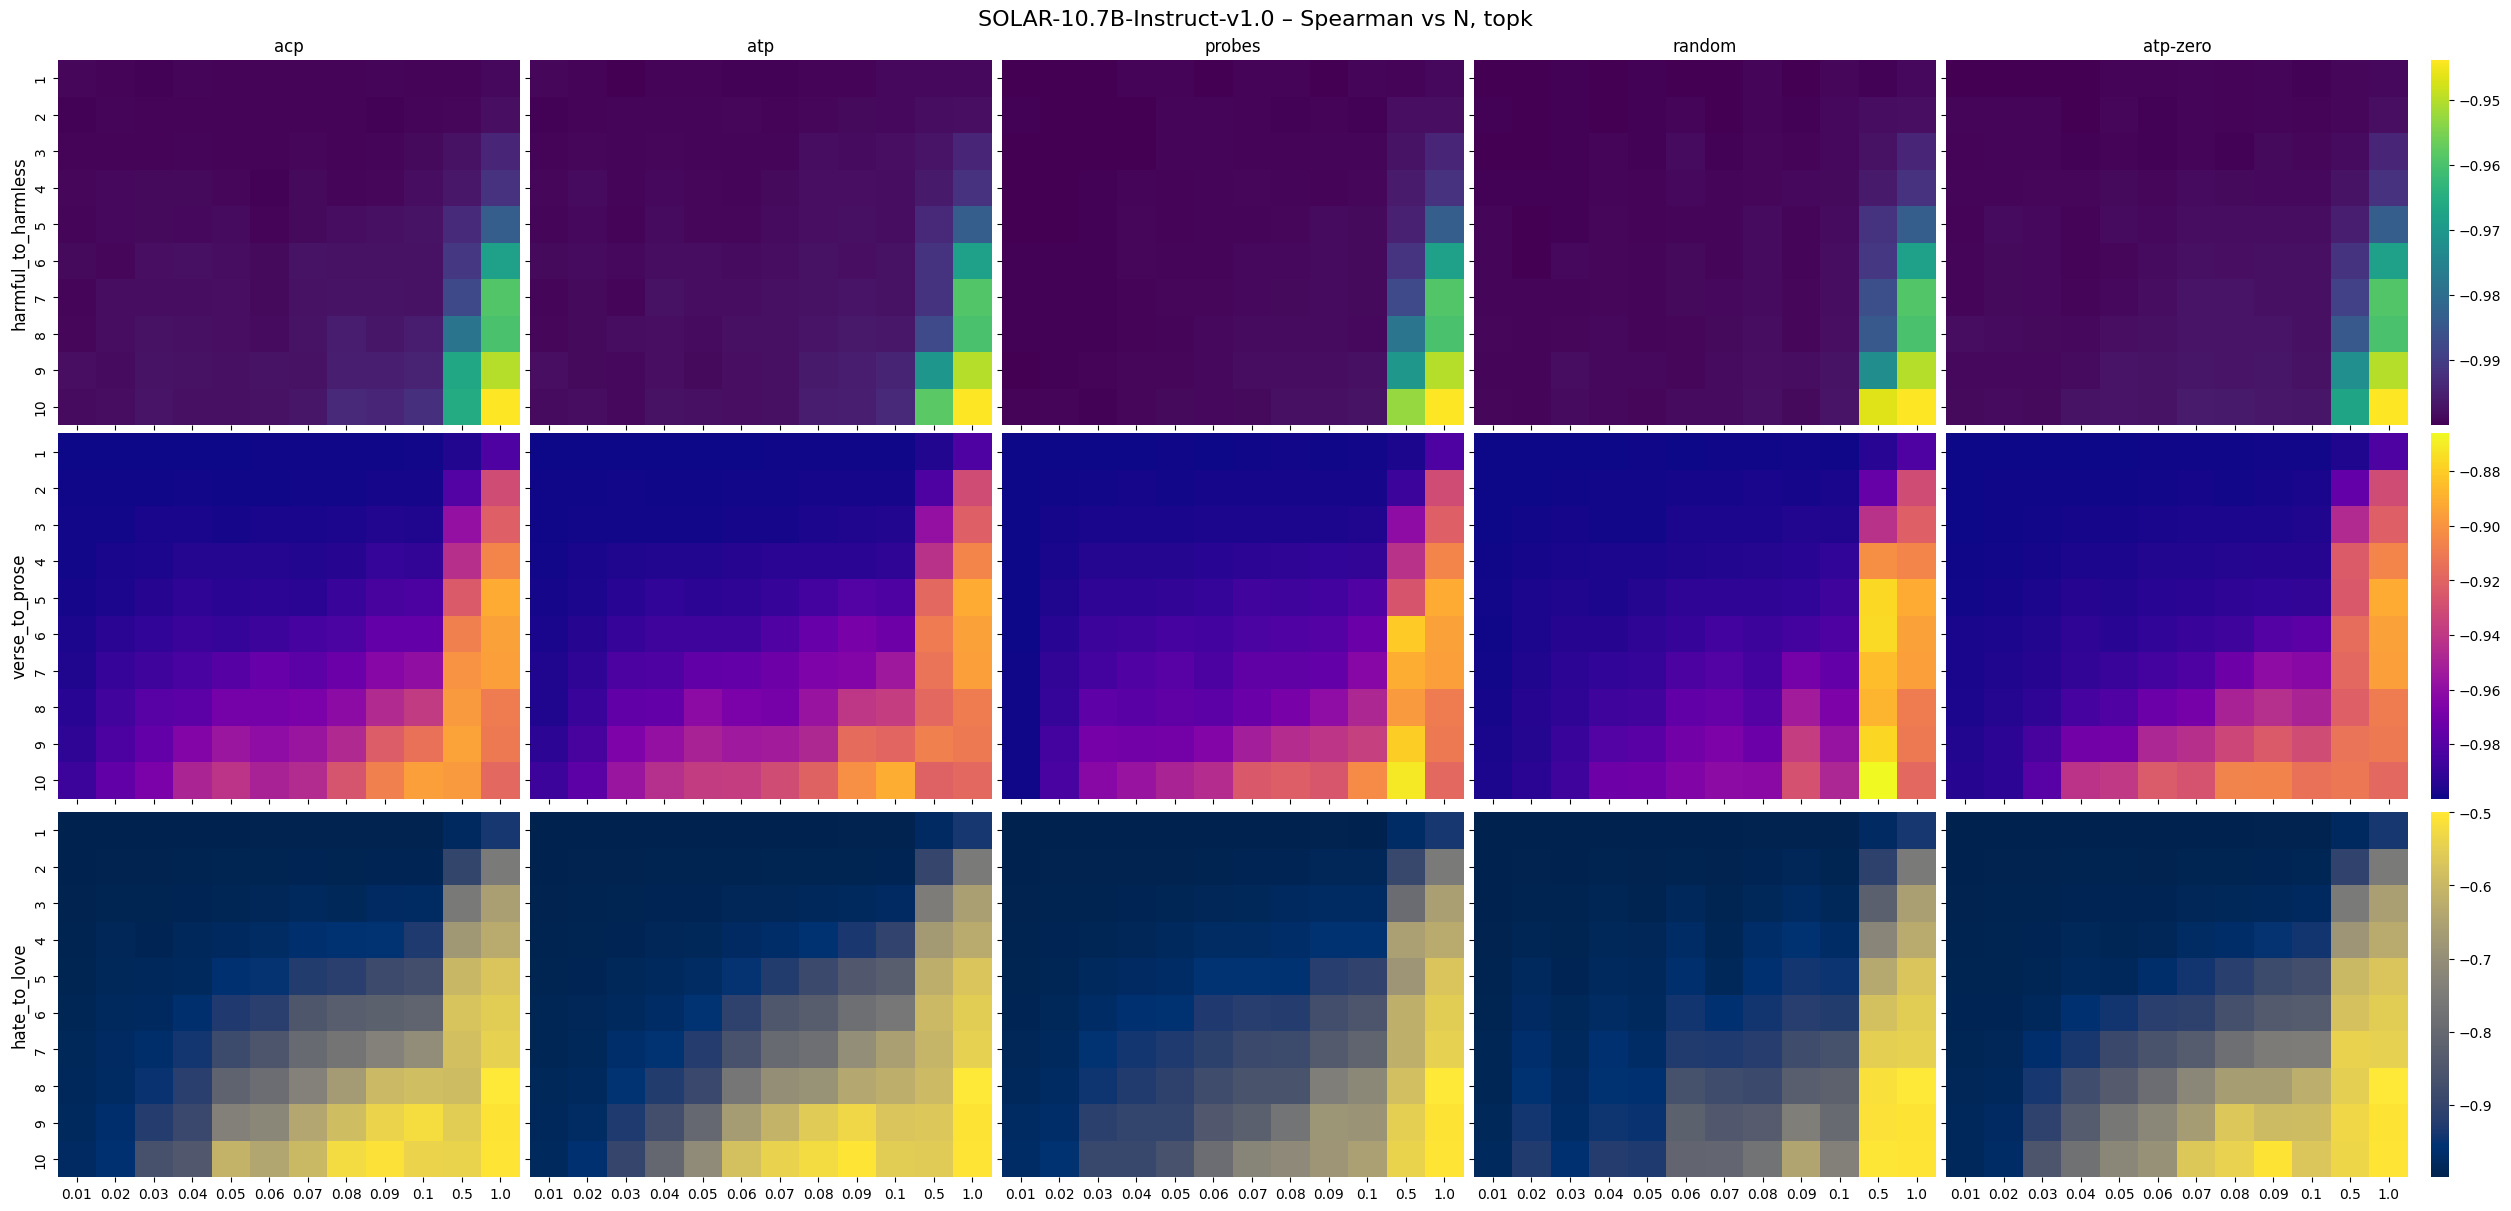

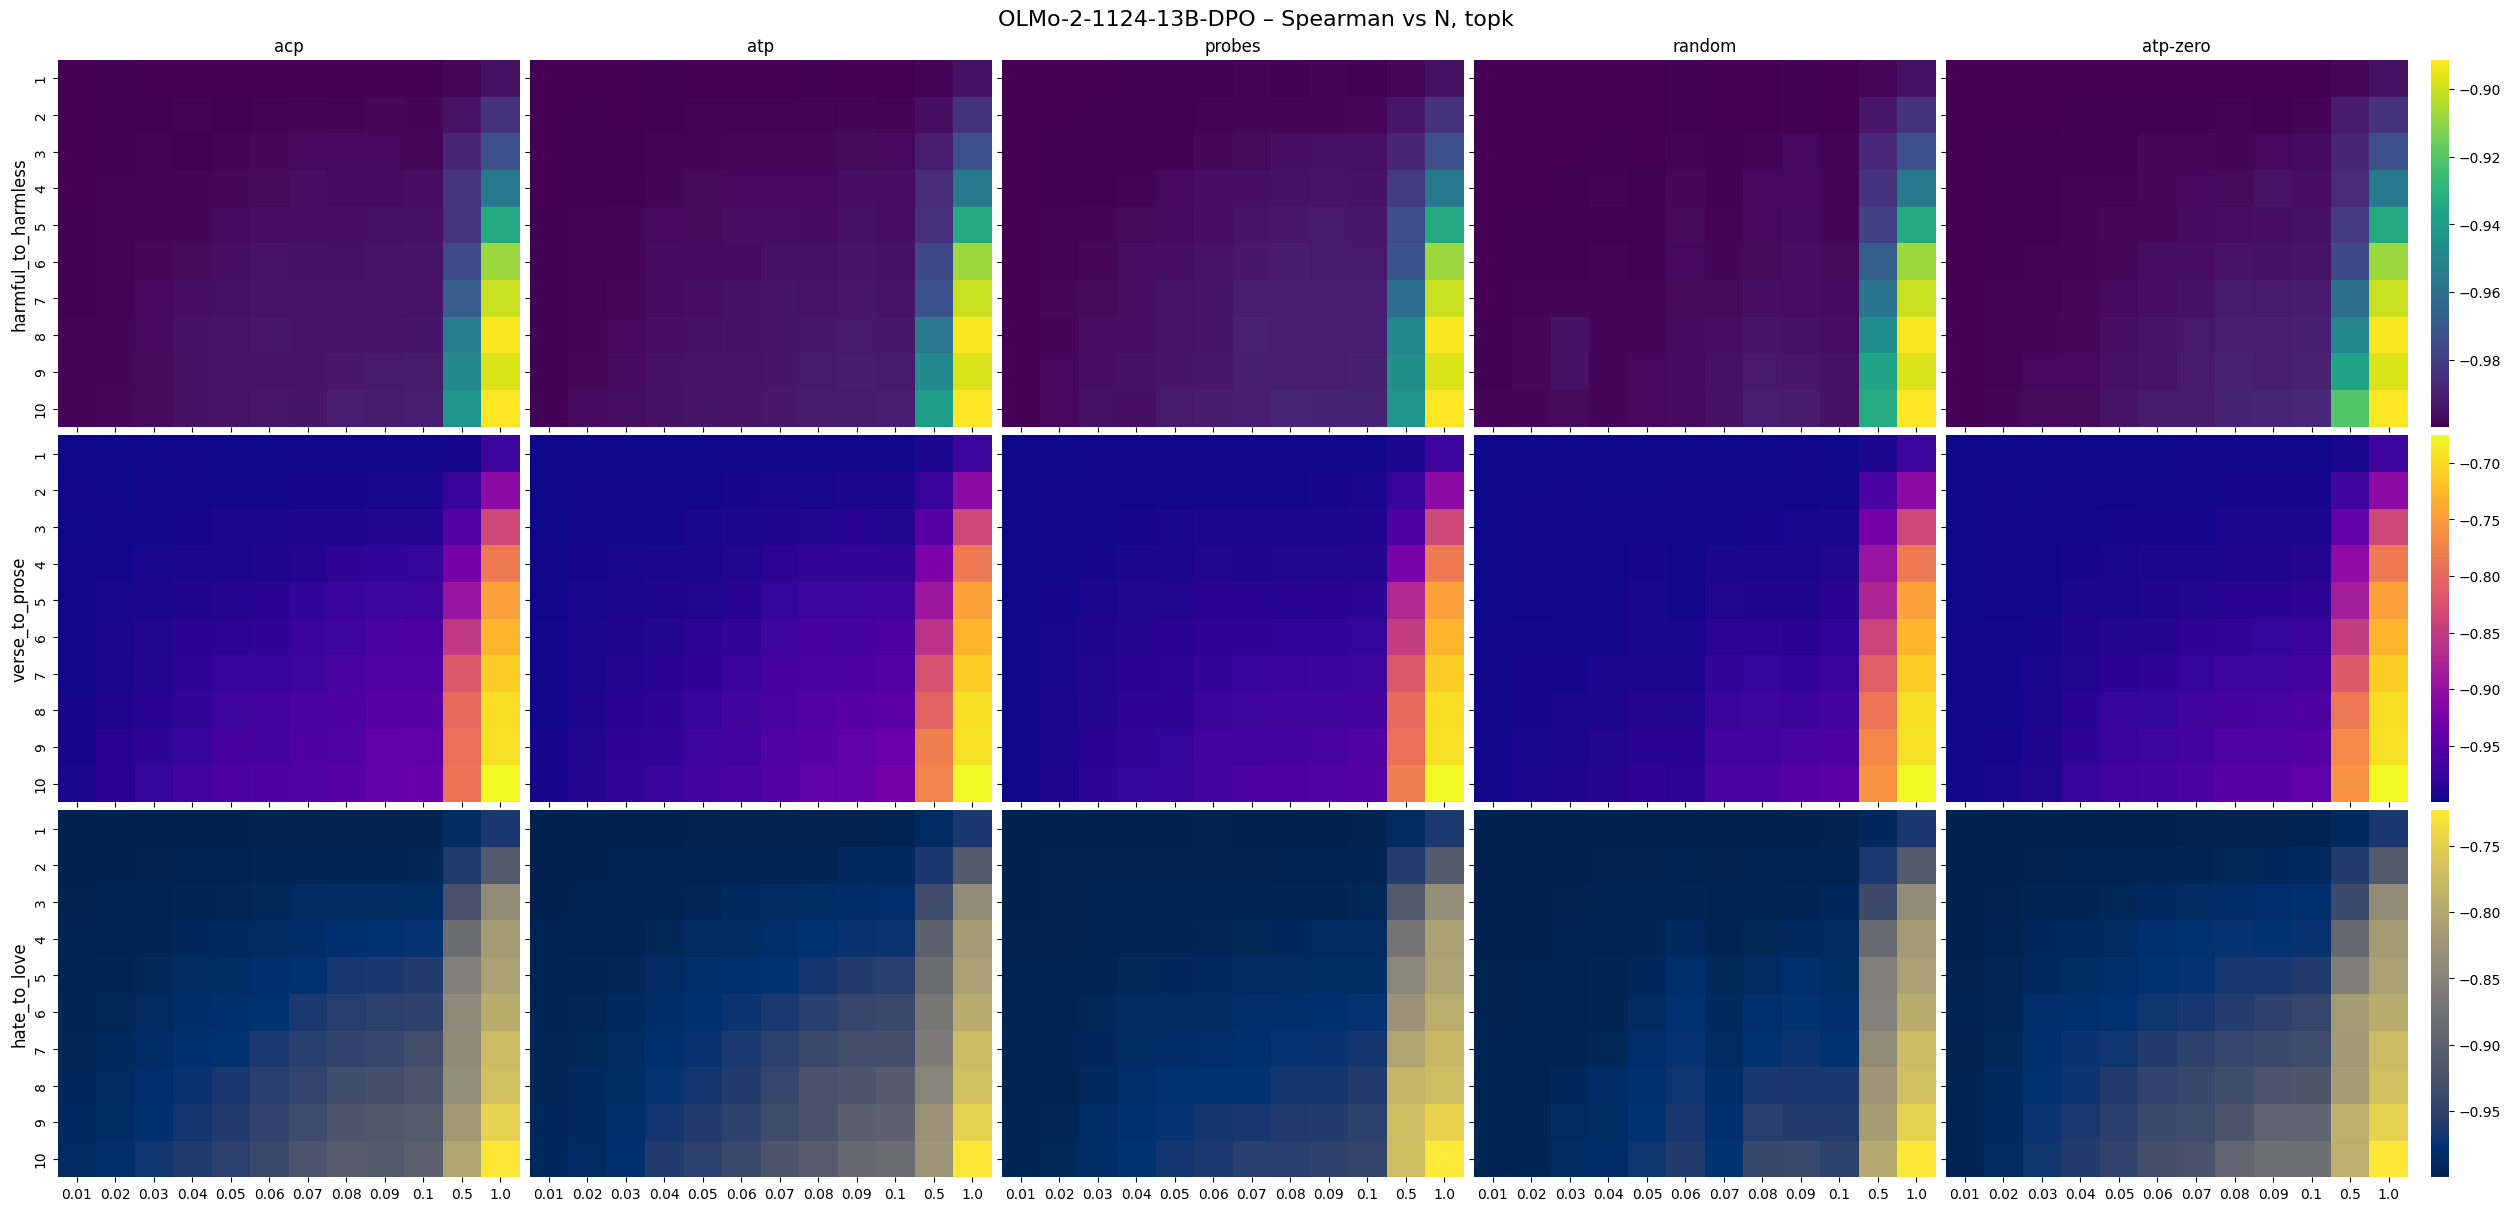

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
colormaps = [cm.get_cmap('viridis'), cm.get_cmap('plasma'), cm.get_cmap('cividis')]
def plot_metric_heatmaps(df, metric):
    models = df["model"].unique()
    topks = sorted(df["topk"].unique())
    Ns = sorted(df["N"].unique())

    for model in models:
        sub = df[df["model"] == model]
        fig, axes = plt.subplots(
            nrows=3, ncols=5,
            figsize=(25, 12),
            constrained_layout=True,
            sharex=True, sharey=True
        )

        tasks = ["harmful_to_harmless", "verse_to_prose", "hate_to_love"]
        methods = ["acp", "atp", "probes", "random", "atp-zero"]

        for i, task in enumerate(tasks):
            task_data = sub[sub["task"] == task]

            # Compute task-level vmin/vmax for normalization
            vmin = task_data[metric].min()
            vmax = task_data[metric].max()

            for j, method in enumerate(methods):
                ax = axes[i, j]
                grid = task_data[task_data["method"] == method]

                if grid.empty:
                    ax.set_visible(False)
                    continue

                pivot = grid.pivot_table(
                    index="N", columns="topk", values=metric
                ).reindex(index=Ns, columns=topks)

                sns.heatmap(
                    pivot, ax=ax, cmap=colormaps[i],
                    vmin=vmin, vmax=vmax,  # <-- normalization within task
                    cbar=(j == 4), annot=False
                )

                if i == 0:
                    ax.set_title(method, fontsize=12)
                if j == 0:
                    ax.set_ylabel(task, fontsize=12)
                else:
                    ax.set_ylabel("")
                ax.set_xlabel("")

        fig.suptitle(f"{model} – {metric} vs N, topk", fontsize=16)
        plt.show()

df = pd.read_csv('logits-eval-old.csv')
plot_metric_heatmaps(df, "Spearman")